In [1]:
import pandas as pd
import os

df = pd.read_json('/home/weisi/TemporalAssessment/data/BIOASQ/BioASQ_formatted.json', lines=True)
df.dtypes

id              object
body            object
exact_answer    object
ideal_answer    object
type            object
snippets        object
year             int64
dtype: object

In [2]:

# calculate snippets length
df['snippets_length'] = df['snippets'].apply(len)

intervals = {
    '2013-2015': (2013, 2015),
    '2016-2018': (2016, 2018),
    '2019-2020': (2019, 2020),
    '2021-2022': (2021, 2022),
}

average_lengths = {}


for interval, (start_year, end_year) in intervals.items():
    interval_data = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    average_length = interval_data['snippets_length'].mean()
    average_lengths[interval] = average_length

# 打印结果
for interval, avg_length in average_lengths.items():
    print(f"{interval}: average snippets length = {avg_length}")


2013-2015: average snippets length = 2927.531100478469
2016-2018: average snippets length = 2784.477501678979
2019-2020: average snippets length = 1649.7530120481927
2021-2022: average snippets length = 2181.5214285714287


In [3]:
# simplely split the text
def tokenize(text):
    return text.split()

# save splitted tokens
df['tokens'] = df['snippets'].apply(tokenize)

In [4]:

unique_words_by_interval = {}

for interval, (start_year, end_year) in intervals.items():
    interval_data = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    unique_words = set(word for tokens in interval_data['tokens'] for word in tokens)
    unique_words_by_interval[interval] = unique_words

    print(f"Unique words count for {interval}: {len(unique_words)}")

for interval_a, words_a in unique_words_by_interval.items():
    for interval_b, words_b in unique_words_by_interval.items():
        if interval_a < interval_b:  # avoid compare same pair twice
            intersection = words_a.intersection(words_b)
            print(f"Overlap between {interval_a} and {interval_b}: {len(intersection)} words")

Unique words count for 2013-2015: 54162
Unique words count for 2016-2018: 54129
Unique words count for 2019-2020: 28701
Unique words count for 2021-2022: 37949
Overlap between 2013-2015 and 2016-2018: 19393 words
Overlap between 2013-2015 and 2019-2020: 12997 words
Overlap between 2013-2015 and 2021-2022: 15256 words
Overlap between 2016-2018 and 2019-2020: 13851 words
Overlap between 2016-2018 and 2021-2022: 15977 words
Overlap between 2019-2020 and 2021-2022: 12104 words


In [32]:
for interval, (start_year, end_year) in intervals.items():
    interval_data = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    print(f"Average token number in snippets for {interval}: {interval_data['tokens'].apply(len).mean()}")

Average token number in snippets for 2013-2015: 412.1060606060606
Average token number in snippets for 2016-2018: 389.65681665547345
Average token number in snippets for 2019-2020: 229.66967871485943
Average token number in snippets for 2021-2022: 303.9010204081633


In [13]:
def calculate_average_answer_length(answers):
    if not answers:  
        return 0
    total_length = sum(len(item) for answer in answers for item in answer)
    total_count = len(answers)
    average_length = total_length / total_count if total_count else 0
    return average_length

calculate_average_answer_length(['10 nanometers', '10 nm'])

9.0

In [16]:
df['average_answer_length'] = df['exact_answer'].apply(calculate_average_answer_length)

results = []
intervals = {
    '2013-2015': (2013, 2015),
    '2016-2018': (2016, 2018),
    '2019-2020': (2019, 2020),
    '2021-2022': (2021, 2022),
}
for interval, (start, end) in intervals.items():
    interval_df = df[(df['year'] >= start) & (df['year'] <= end)]
    for question_type in interval_df['type'].unique():
        average_length = interval_df[interval_df['type'] == question_type]['average_answer_length'].mean()
        results.append({'year_interval': f"{interval}", 'type': question_type, 'average_answer_length': average_length})

#here average_answer_length means the average exact_answer(a list) length in each question
#eg. ['ans1', 'ans2']: [len(ans1)+len(ans2)]/2

results_df = pd.DataFrame(results)

results_df.head()

,year_interval,type,average_answer_length
0,2013-2015,summary,531.716312
1,2013-2015,list,103.717634
2,2013-2015,yesno,2.860795
3,2013-2015,factoid,26.823280
4,2016-2018,list,68.438008


In [17]:
print(results_df)

   year_interval     type  average_answer_length
0      2013-2015  summary             531.716312
1      2013-2015     list             103.717634
2      2013-2015    yesno               2.860795
3      2013-2015  factoid              26.823280
4      2016-2018     list              68.438008
5      2016-2018  factoid              28.481521
6      2016-2018    yesno               2.789203
7      2016-2018  summary             380.585781
8      2019-2020  factoid              28.970430
9      2019-2020     list              63.167689
10     2019-2020    yesno               2.646048
11     2019-2020  summary             351.783246
12     2021-2022  factoid              22.795920
13     2021-2022     list              72.551557
14     2021-2022  summary             293.189634
15     2021-2022    yesno               2.656904


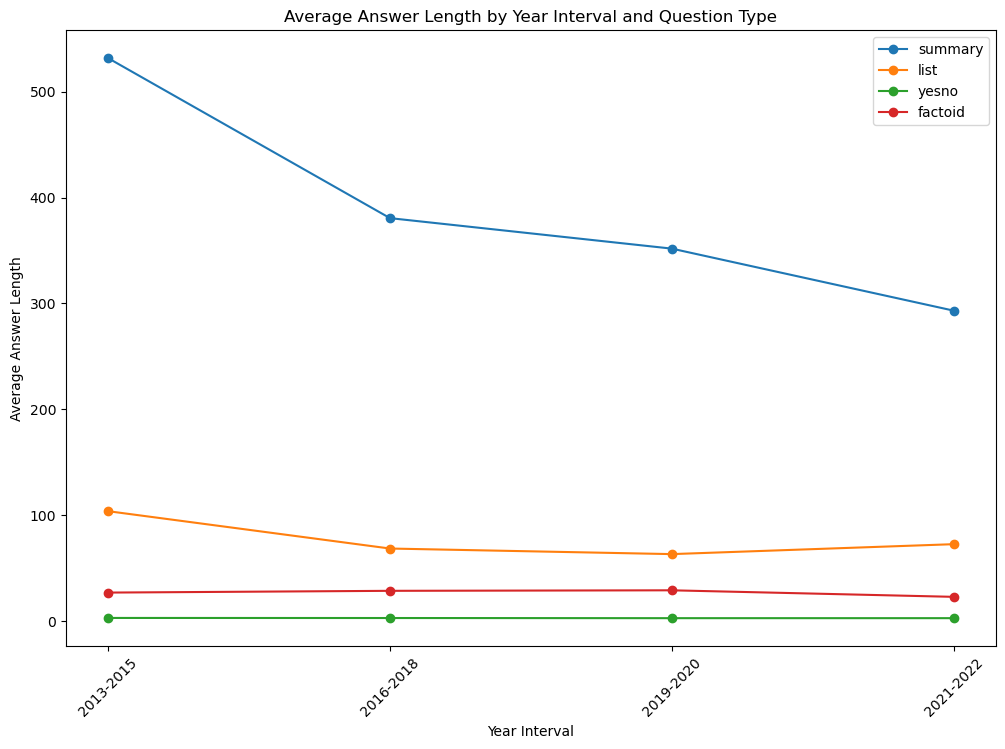

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for question_type in results_df['type'].unique():
    subset = results_df[results_df['type'] == question_type]
    plt.plot(subset['year_interval'], subset['average_answer_length'], label=question_type, marker='o')

plt.title('Average Answer Length by Year Interval and Question Type')
plt.xlabel('Year Interval')
plt.ylabel('Average Answer Length')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_data = []
intervals = {
    '2013-2015': (2013, 2015),
    '2016-2018': (2016, 2018),
    '2019-2020': (2019, 2020),
    '2021-2022': (2021, 2022),
}

for interval, (start, end) in intervals.items():
    interval_df = df[(df['year'] >= start) & (df['year'] <= end)]
    interval_df['year_interval'] = interval  # add a column named year_interval
    plot_data.append(interval_df[['year_interval', 'type', 'average_answer_length','exact_answer','snippets']])

# combine all data
plot_df = pd.concat(plot_data)



/tmp/ipykernel_1140096/3464828814.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_df['year_interval'] = interval  # add a column named year_interval
/tmp/ipykernel_1140096/3464828814.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_df['year_interval'] = interval  # add a column named year_interval
/tmp/ipykernel_1140096/3464828814.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

/tmp/ipykernel_1140096/3635254175.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/pytho

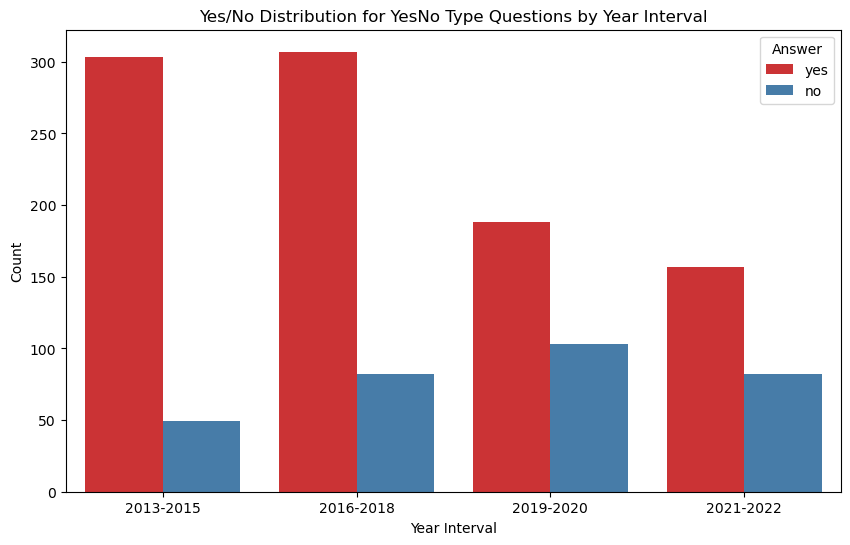

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 过滤掉'yesno'类型的数据
plot_df_filtered = plot_df[plot_df['type'] != 'yesno']

# 单独为'yesno'类型问题绘制'yes'和'no'的分布
# 首先，从原始DataFrame中提取'yesno'类型的数据
yesno_df = plot_df[plot_df['type'] == 'yesno']

# 由于exact_answer是['yes']或['no']的列表形式，我们需要将其展开为单个值
yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])

# 使用countplot来绘制'yes'和'no'的分布情况
plt.figure(figsize=(10, 6))
sns.countplot(x='year_interval', hue='exact_answer', data=yesno_df, palette="Set1")
plt.title('Yes/No Distribution for YesNo Type Questions by Year Interval')
plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.legend(title='Answer')
plt.show()


/tmp/ipykernel_1140096/787994521.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3

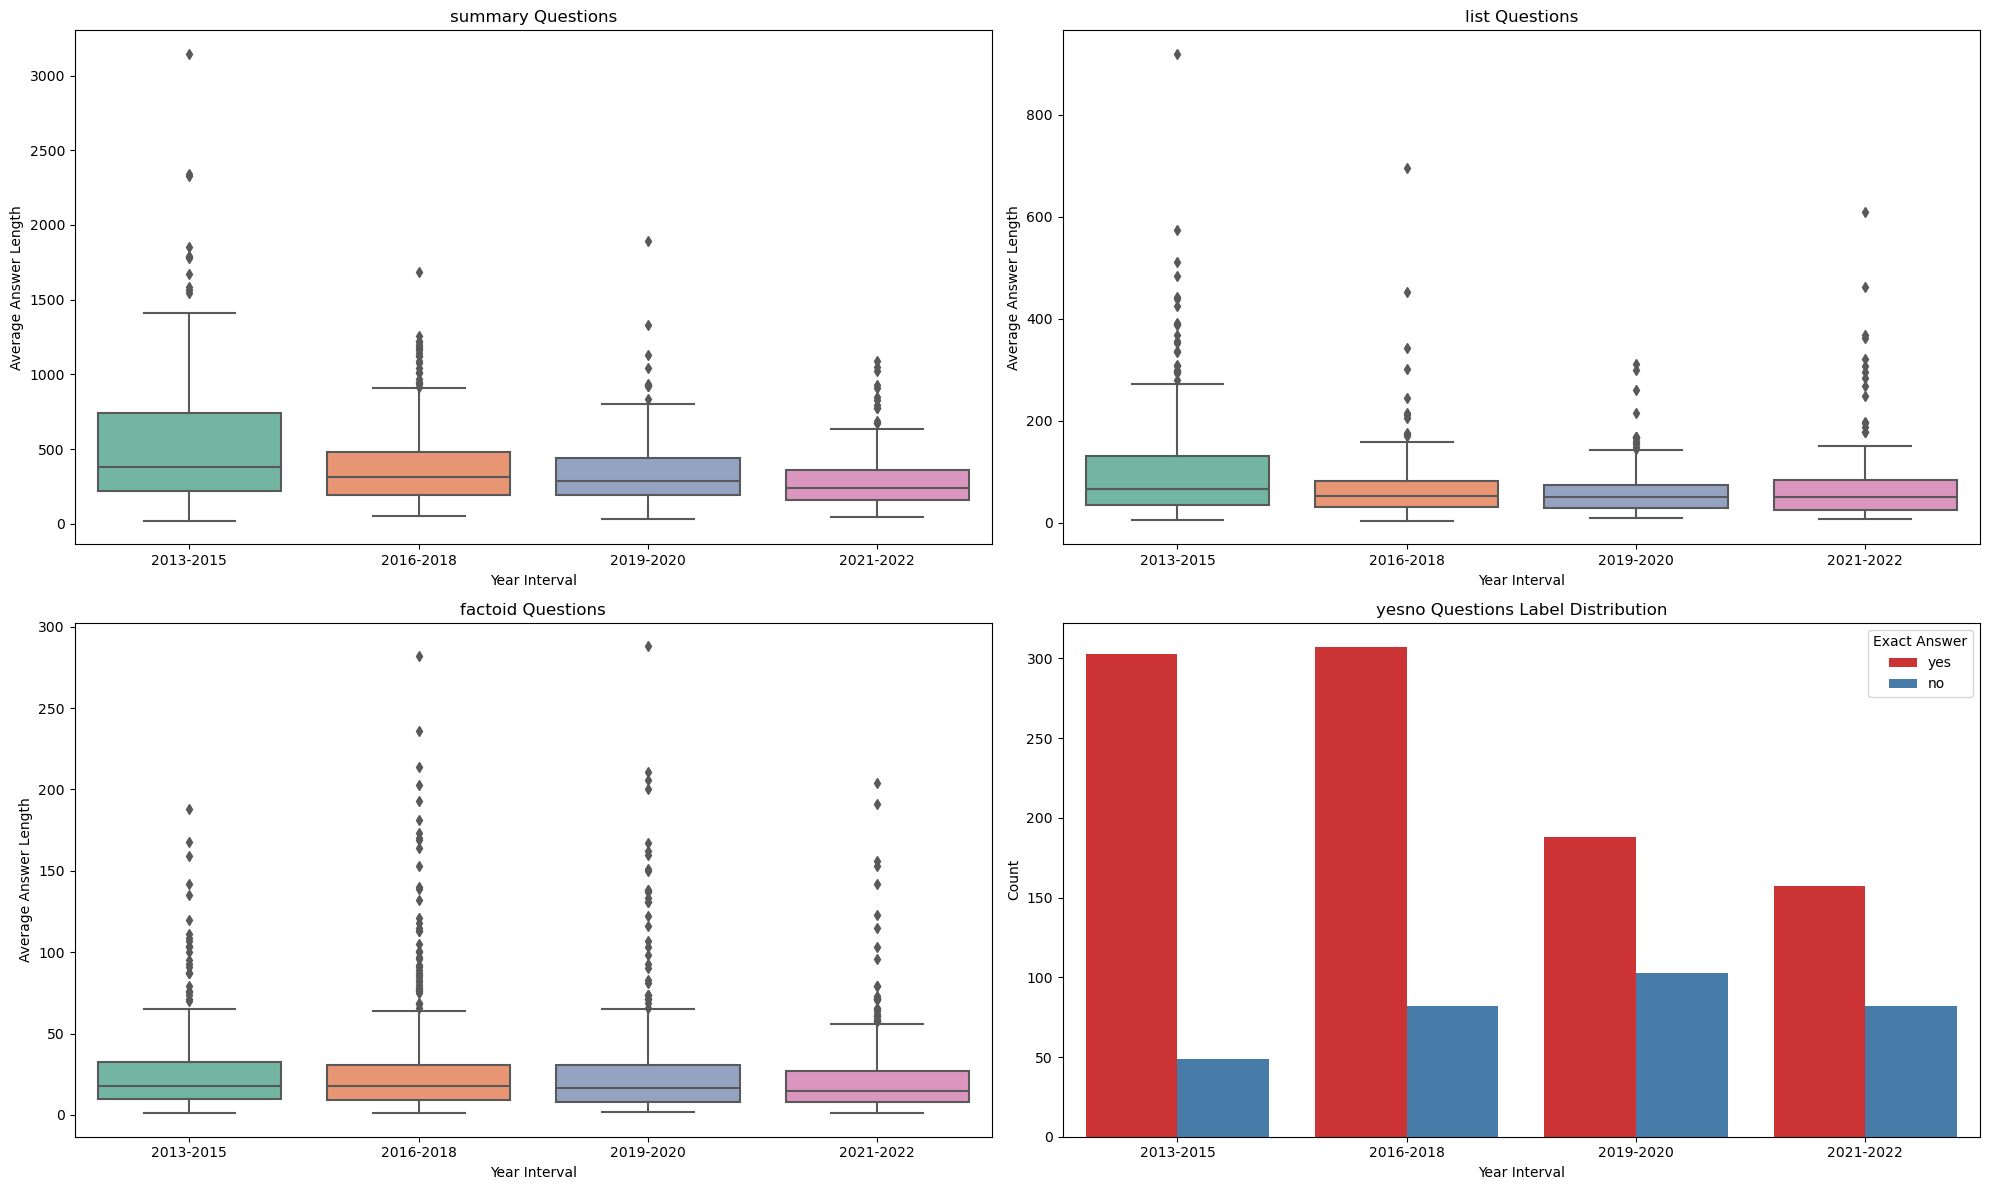

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分别处理非yesno类型的数据和yesno类型的数据
plot_df_filtered = plot_df[plot_df['type'] != 'yesno']
yesno_df = plot_df[plot_df['type'] == 'yesno']

# 为yesno类型问题的exact_answer展开列表为单个值
yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])

# 创建一个画布和子图结构，准备绘制前三个箱线图和一个直方图
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.flatten()  # 将2x2的轴数组扁平化处理，以方便索引

# 绘制前三个问题类型的箱线图
for i, question_type in enumerate(plot_df_filtered['type'].unique()):
    sns.boxplot(data=plot_df_filtered[plot_df_filtered['type'] == question_type],
                x='year_interval', y='average_answer_length', ax=axes[i], palette="Set2")
    axes[i].set_title(f'{question_type} Questions')
    axes[i].set_xlabel('Year Interval')
    axes[i].set_ylabel('Average Answer Length')
#showfliers=False
# 绘制yesno问题类型的标签分布直方图
sns.countplot(data=yesno_df, x='year_interval', hue='exact_answer', ax=axes[3], palette="Set1")
axes[3].set_title('yesno Questions Label Distribution')
axes[3].set_xlabel('Year Interval')
axes[3].set_ylabel('Count')
axes[3].legend(title='Exact Answer')

# 调整整体布局
plt.tight_layout()
plt.show()


/tmp/ipykernel_1140096/3939067415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python

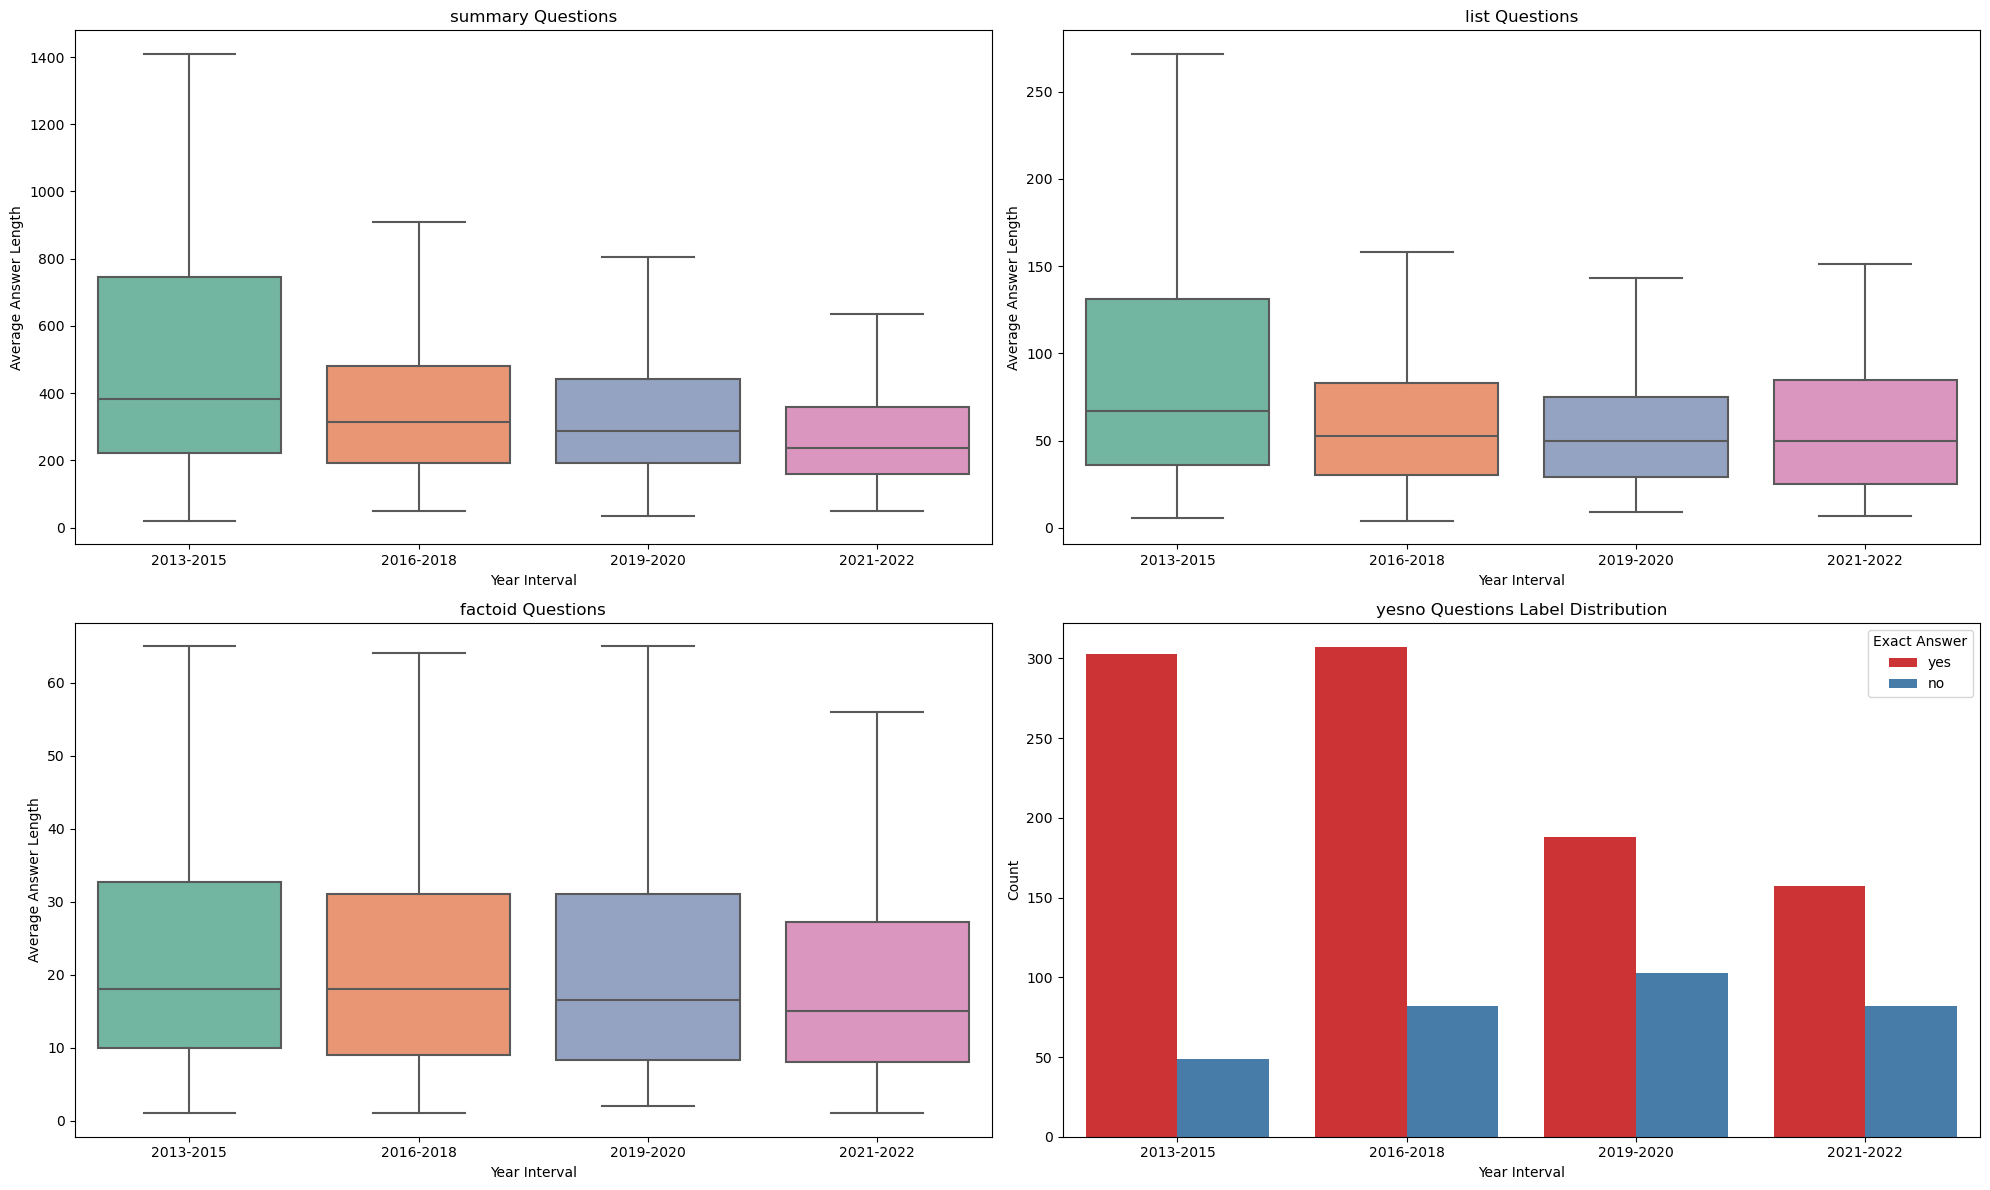

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分别处理非yesno类型的数据和yesno类型的数据
plot_df_filtered = plot_df[plot_df['type'] != 'yesno']
yesno_df = plot_df[plot_df['type'] == 'yesno']

# 为yesno类型问题的exact_answer展开列表为单个值
yesno_df['exact_answer'] = yesno_df['exact_answer'].apply(lambda x: x[0])

# 创建一个画布和子图结构，准备绘制前三个箱线图和一个直方图
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.flatten()  # 将2x2的轴数组扁平化处理，以方便索引

# 绘制前三个问题类型的箱线图
for i, question_type in enumerate(plot_df_filtered['type'].unique()):
    sns.boxplot(data=plot_df_filtered[plot_df_filtered['type'] == question_type],
                x='year_interval', y='average_answer_length', ax=axes[i],showfliers=False, palette="Set2")
    axes[i].set_title(f'{question_type} Questions')
    axes[i].set_xlabel('Year Interval')
    axes[i].set_ylabel('Average Answer Length')
#
# 绘制yesno问题类型的标签分布直方图
sns.countplot(data=yesno_df, x='year_interval', hue='exact_answer', ax=axes[3], palette="Set1")
axes[3].set_title('yesno Questions Label Distribution')
axes[3].set_xlabel('Year Interval')
axes[3].set_ylabel('Count')
axes[3].legend(title='Exact Answer')

# 调整整体布局
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np

# 假设plot_df是已经准备好的DataFrame，并且已经计算了average_answer_length

# 初始化存储结果的列表
outliers_info = []

# 遍历每种问题类型和年份区间的组合
for question_type in plot_df['type'].unique():
    for year_interval in plot_df['year_interval'].unique():
        subset = plot_df[(plot_df['type'] == question_type) & (plot_df['year_interval'] == year_interval)]
        if subset.empty:
            continue
        
        # 计算Q1, Q3, 和 IQR
        Q1 = subset['average_answer_length'].quantile(0.25)
        Q3 = subset['average_answer_length'].quantile(0.75)
        IQR = Q3 - Q1
        
        # 定义异常点条件
        outliers = subset[(subset['average_answer_length'] < (Q1 - 1.5 * IQR)) | 
                          (subset['average_answer_length'] > (Q3 + 1.5 * IQR))]
        
        # 计算每个异常点的权重（与Q1或Q3的距离）
        outliers['weight'] = outliers['average_answer_length'].apply(lambda x: min(abs(x - Q1), abs(x - Q3)))
        
        # 计算异常点数量和权重和
        num_outliers = len(outliers)
        weight_sum = outliers['weight'].sum()

        outliers_info.append({
            'type': question_type,
            'year_interval': year_interval,
            'num_outliers': num_outliers,
            'weight_sum': weight_sum
        })

# 转换为DataFrame
outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)

       type year_interval  num_outliers    weight_sum
0   summary     2013-2015            11  13202.750000
1   summary     2016-2018            21  13341.666667
2   summary     2019-2020             9   5960.416667
3   summary     2021-2022            13   6413.200000
4      list     2013-2015            22   5913.041667
5      list     2016-2018            11   2277.083333
6      list     2019-2020            13   1552.000000
7      list     2021-2022            15   3196.133333
8     yesno     2013-2015            49     49.000000
9     yesno     2016-2018            82     82.000000
10    yesno     2019-2020             0      0.000000
11    yesno     2021-2022             0      0.000000
12  factoid     2013-2015            24   1745.500000
13  factoid     2016-2018            41   3719.000000
14  factoid     2019-2020            31   2934.000000
15  factoid     2021-2022            27   1745.178571


/tmp/ipykernel_1140096/1178588860.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['weight'] = outliers['average_answer_length'].apply(lambda x: min(abs(x - Q1), abs(x - Q3)))
/tmp/ipykernel_1140096/1178588860.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['weight'] = outliers['average_answer_length'].apply(lambda x: min(abs(x - Q1), abs(x - Q3)))
/tmp/ipykernel_1140096/1178588860.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/weisi/anaconda3/envs/env310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

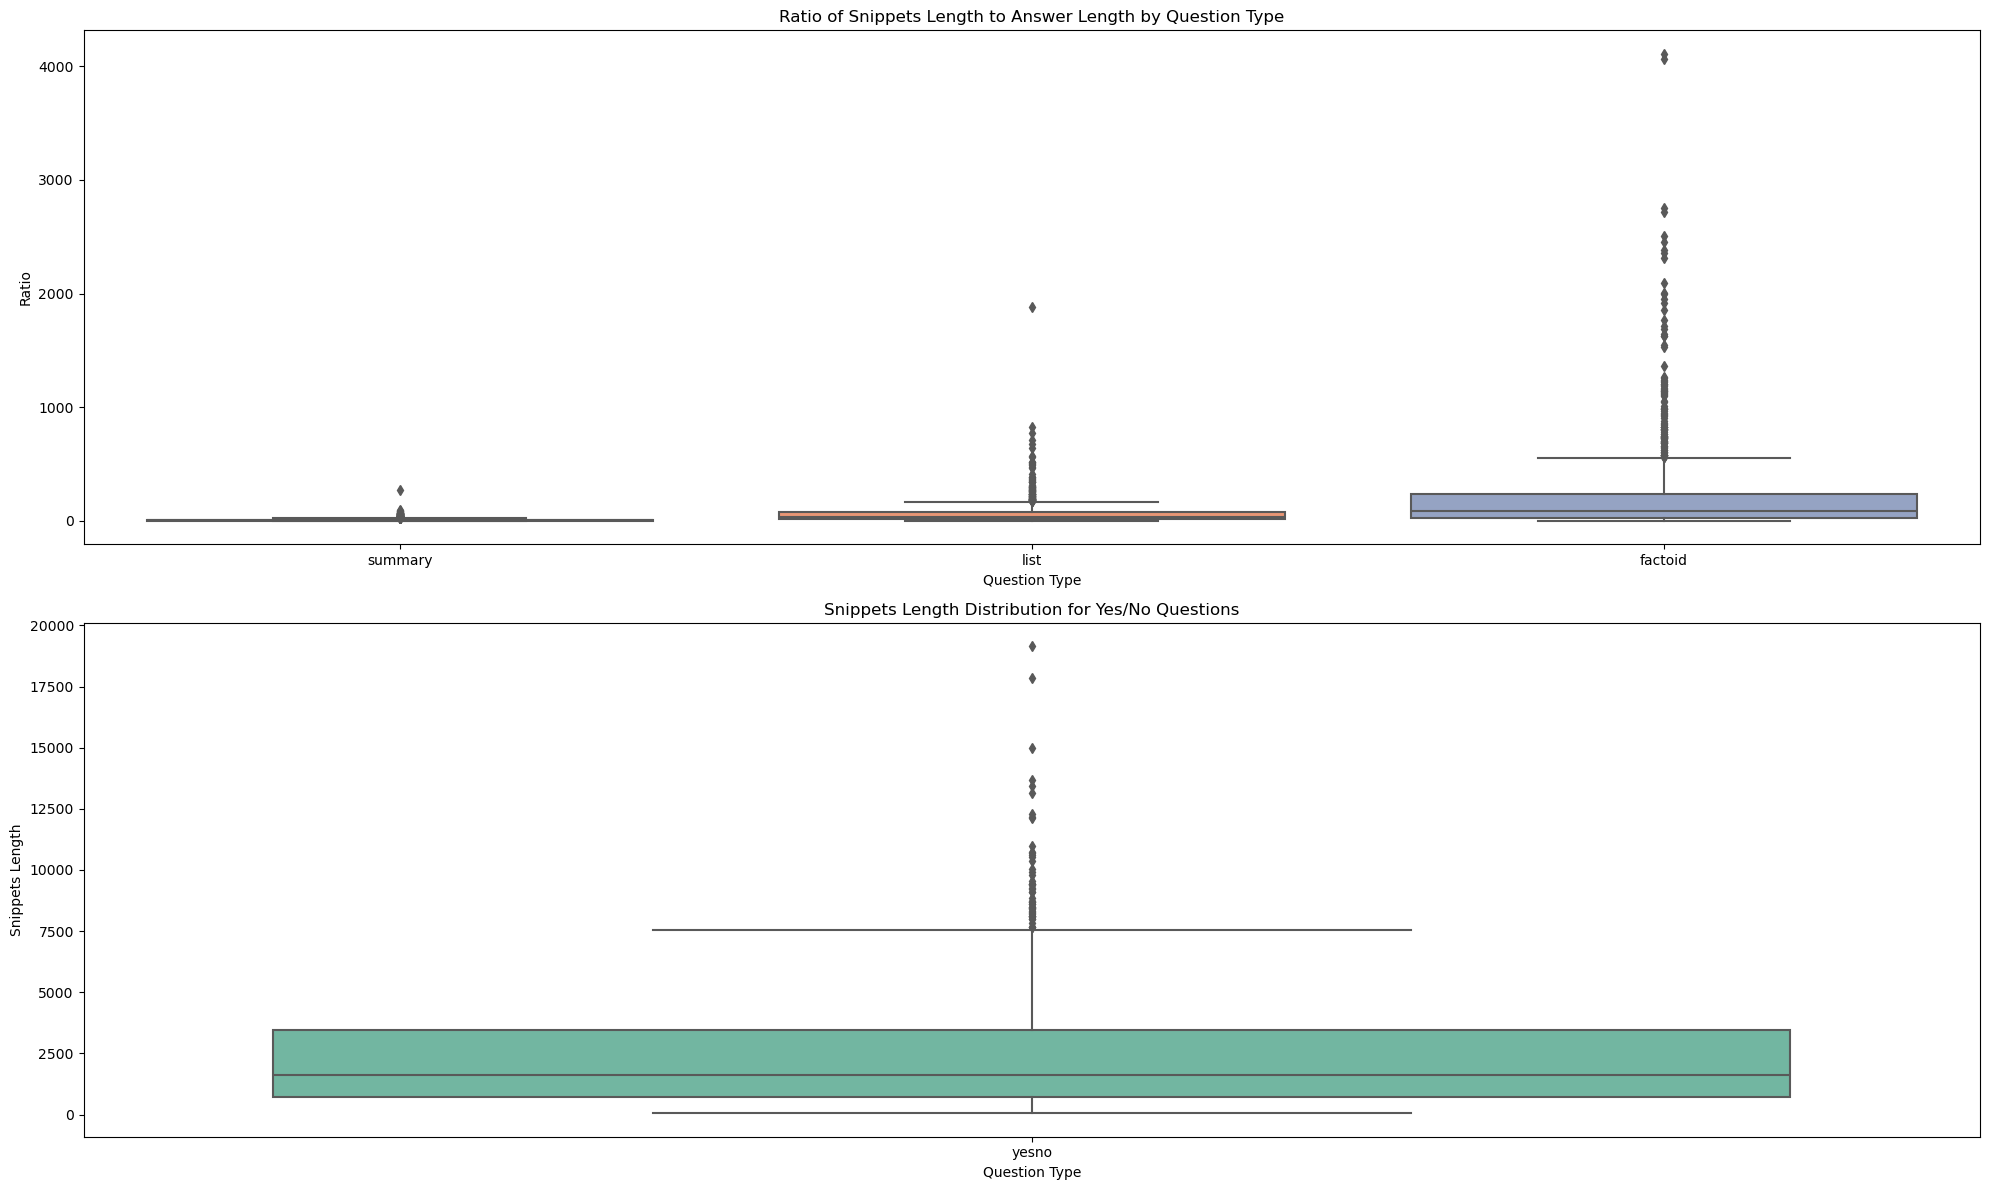

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算非yes/no问题的snippets长度和answer长度的比值
plot_df['ratio'] = plot_df.apply(lambda x: len(x['snippets']) / len(x['exact_answer'][0]) if x['type'] != 'yesno' else None, axis=1)

# 分离yesno和非yesno数据
yesno_df = plot_df[plot_df['type'] == 'yesno'].copy()
non_yesno_df = plot_df[plot_df['type'] != 'yesno'].copy()

# 计算yesno问题的snippets长度
yesno_df['snippets_length'] = yesno_df['snippets'].apply(len)

# 设置画布大小
plt.figure(figsize=(20, 12))

# 创建子图
ax1 = plt.subplot(2, 1, 1)
sns.boxplot(data=non_yesno_df, x='type', y='ratio', palette="Set2")
ax1.set_title('Ratio of Snippets Length to Answer Length by Question Type')
ax1.set_xlabel('Question Type')
ax1.set_ylabel('Ratio')

ax2 = plt.subplot(2, 1, 2)
sns.boxplot(data=yesno_df, x='type', y='snippets_length', palette="Set2")
ax2.set_title('Snippets Length Distribution for Yes/No Questions')
ax2.set_xlabel('Question Type')
ax2.set_ylabel('Snippets Length')

plt.tight_layout()
plt.show()
